In [2]:
# Import essential, stat and machine learning libraries
import warnings
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint, adfuller, kpss

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [1]:
# Import libraries for deeplearning
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers import Bidirectional
from tensorflow.keras import Sequential
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


2022-12-18 19:27:42.283607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
""" Géneral config and parameters """

# File to import
filename = 'historical_emissions.csv'

# DataFrame configuration
country = 'France'
sector = 'Transportation'
gas = 'CO2'

# Parameters for Machine Learning models - Defines shape of window for pre-precessing features and choose model
window = 5  
model_name = ["Linear Regression", 'SVM'] 

# Parameters for statistical model ARIMA - set values for p,d,q order
p_values = range(0, 4) 
d_values = range(0, 4) 
q_values = range(0, 4)  


# Parameters for deep learning configuration 
deep_learning_config = {'Vanilla LSTM':{"n_step":5},
                         'Stacked LSTM':{"n_step":3},
                         'Bidirectional LSTM':{"n_step":3}
                       }
cnn_config = {'CNN LSTM':{"n_steps": 4,
                          "n_seq": 2,
                          "n_steps_seq": 2},
              'Conv LSTM':{"n_steps": 4,
                           "n_seq": 2,
                           "n_steps_seq": 2}
             }


In [4]:
class preprocess_and_evaluate:
    """ 
    Preprocess Data Frame and allows criterias selection such as Country, Sector or Gas.
    calculates scores for model evaluation : mae, rmse, mape, r2
        
    """
    
    def __init__(self, country: str, sector: str, gas: str):
        self.country = country
        self.sector = sector
        self.gas = gas
    
    def get_df(country: str, sector: str, gas: str) -> pd.DataFrame:
        """ Get and initialize df """
        
        df = pd.read_csv('final_df_europe.csv')
        df = df.set_index('year')
        df = df[(df['country'] == country) & (df['sector'] == sector) & (df['gas'] == gas)]
        df = df.drop(['Unnamed: 0', 'country', 'sector', 'gas'], axis=1)
        df.index = pd.to_datetime(df.index, format='%Y')
        df = df.sort_values(by='year')
        
        return df
    
    def calculate_scores(y_true: np.array , y_pred: np.array) :
        """ Calculate scores for models : mar, rmse, mape, r2 """
        
        mae = round(mean_absolute_error(y_true,y_pred), 3)
        rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 3)
        mape = round(mean_absolute_percentage_error(y_true, y_pred), 3)
        r2 = round(r2_score(y_true,y_pred), 3)
        
        return mae, rmse, mape, r2
    
    def split_sequence(sequence: np.array, n_steps: int) -> (np.array, np.array):
        """ Split a univariate sequence into samples - Used for deep learning """
        
        X, y = list(), list()
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)


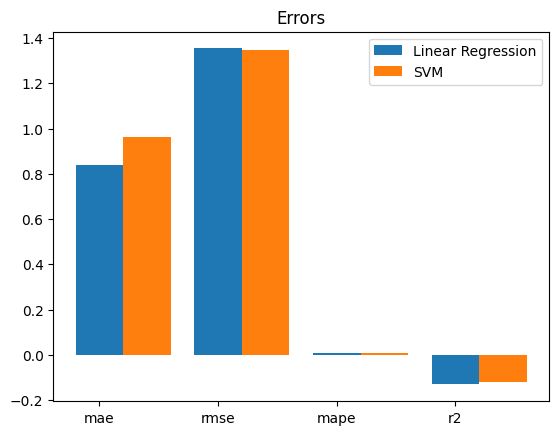

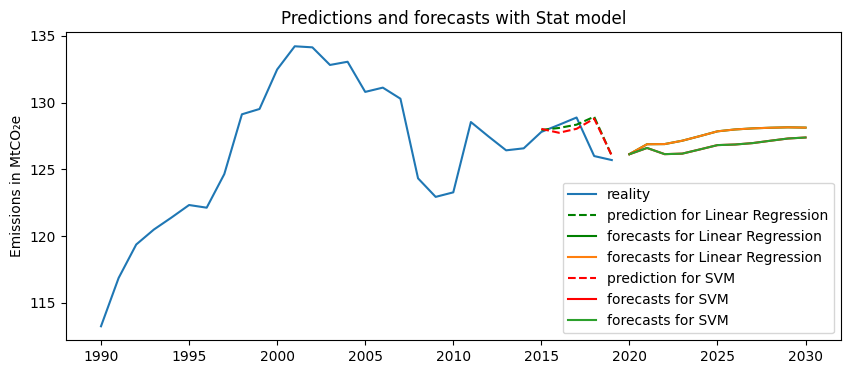

In [5]:
class machine_learning_models:
    """ 
    Preprocess, fit, predit, show errors and visualisation for Machine Learning models : Linear Regression and SVM
    """

    def __init__(self, window:str):
        self.df = preprocess_and_evaluate.get_df(country, sector, gas)
        self.window = window


    def window_dataset(self) -> pd.DataFrame:
        """ 
        Defines new features with implementing a new series of df. 
        This series are shifted from orginal dataframe.
        """
        series = self.df
        L = len(series)
        X = series.values
        new_df = pd.DataFrame(data = X)

        for i in range(self.window):
            y = []
            for i in range(L - 1):
                y.append(X[i+ 1])
            new_df = pd.concat([new_df,pd.DataFrame(y)], axis=1)
            L = L-1
            X = y  
        new_df.columns = ['New_col'+str(i) for i in range(self.window+1)]
        
    
        new_df = new_df.iloc[:-self.window]
        new_df.index = series.index[self.window : self.window + self.df.shape[0]] 
        
        return new_df
    
    def split_df(self) -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
        """ Use window function and split df with train and test sets"""
        
        self.new_df = self.window_dataset()
        self.target = self.new_df['New_col'+str(self.window)]
        self.data = self.new_df.drop('New_col'+str(self.window), axis = 1)

        #training
        X_train, X_test, y_train, y_test = train_test_split(
            self.data, self.target,test_size = 0.2, shuffle = False)
        
        return X_train, X_test, y_train, y_test
    
    
    def predict(self, model_name: str) -> (pd.Series, np.array, pd.DataFrame, pd.Series):
        """ Fit and predict models """
        
        X_train, X_test, y_train, y_test = self.split_df()
        
        if model_name == 'Linear Regression':

            lr = LinearRegression()
            lr.fit(X_train.values, y_train.values)

            #predictions
            y_pred_lr = lr.predict(X_test.values)

            #training on full dataset
            lr = LinearRegression()
            lr.fit(self.data.values, self.target.values)

            #forecasts
            feat = self.new_df.iloc[-1:,1:self.window+1].values
            
            future = []
            for i in range(11):
                pred = lr.predict(feat.reshape(1, -1))
                future.append(pred)
                feat = np.delete(feat,[0])
                feat = np.append(feat, pred)

            forecasts_lr = pd.Series(data = future, index = pd.to_datetime(range(2020,2031), format='%Y')) 
            
            return y_test, y_pred_lr, X_test, forecasts_lr


        elif model_name == 'SVM':

            params = {'C': np.arange(1,11,10),
                      'kernel': ['linear', 'rbf'],
                      'epsilon': np.arange(0.1, 0.5, 0.1)}

            model = SVR()
            cv = GridSearchCV(model, param_grid = params )
            cv.fit(X_train.values, y_train.values)

            #predictions
            y_pred_svm = cv.predict(X_test.values)

            #training on full dataset
            svm = cv.best_estimator_
            svm.fit(self.data.values,self.target.values)

            #forecasts
            feat = self.new_df.iloc[-1:,1:self.window+1].values

            future = []
            for i in range(11):
                pred = svm.predict(feat.reshape(1, -1))
                future.append(pred)
                feat = np.delete(feat,[0])
                feat = np.append(feat,pred)

            forecasts_svm = pd.Series(data = future, index = pd.to_datetime(range(2020,2031), format='%Y') )   

            return y_test, y_pred_svm, X_test, forecasts_svm  
        
    def show_error(self, model_name: str):
        """ Show errors of different models """
        
        df_score = pd.DataFrame(columns=[])
        
        for name in model_name:
        
            y_test, y_pred, X_test, forecasts = self.predict(name)
            score = preprocess_and_evaluate.calculate_scores(y_test, y_pred)
            
            df_temp = pd.DataFrame(score, columns=[name])
            df_score = pd.concat([df_score, df_temp], axis=1)
            
        barWidth = 0.4
        bars = ('mae', 'rmse', 'mape', 'r2')
        x_pos = np.arange(len(bars))
        x2 = [r + barWidth for r in x_pos]
        position_list = [x_pos, x2]
        
        for name, position in zip(enumerate(model_name), position_list):   
            
            plt.bar(position, df_score[name[1]], width = barWidth, label = name[1])

        plt.xticks(x_pos, bars)
        plt.title("Errors")

        plt.legend();

    
    def visulalisation_machine_learning(self, model_name: str):
        """ Show visualisation for reality, test predictions and 10 years forecast """
        
        df = self.df
        plt.figure(figsize = (10,4))
        plt.plot(df.index.year, df, label ='reality')
        plt.ylabel("Emissions in MtCO₂e")
        plt.title(f'Predictions and forecasts with Stat model')
        colors = ['green', 'red']  
   
        for i, name in enumerate(model_name):
            
            y_test, y_pred, X_test, forecasts = self.predict(name)

            plt.plot(X_test.index.year, y_pred, '--', color = colors[i], label = f'prediction for {name}')
            plt.plot(range(2020,2031), forecasts, '-', color = colors[i], label =  f'forecasts for {name}')
            plt.plot(range(2020,2031), forecasts, label =  f'forecasts for {name}')
            
        plt.legend();
            

stat = machine_learning_models(window=window)
stat.show_error(model_name=model_name)
stat.visulalisation_machine_learning(model_name=model_name)

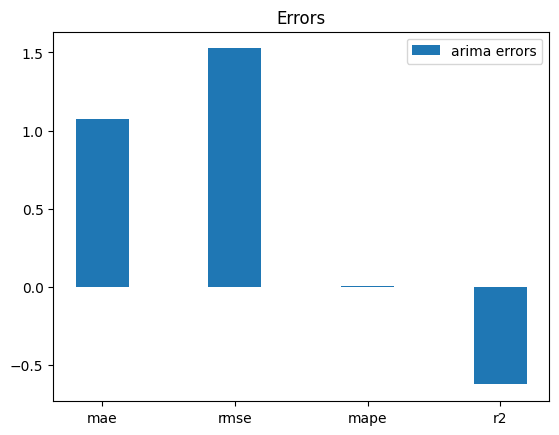

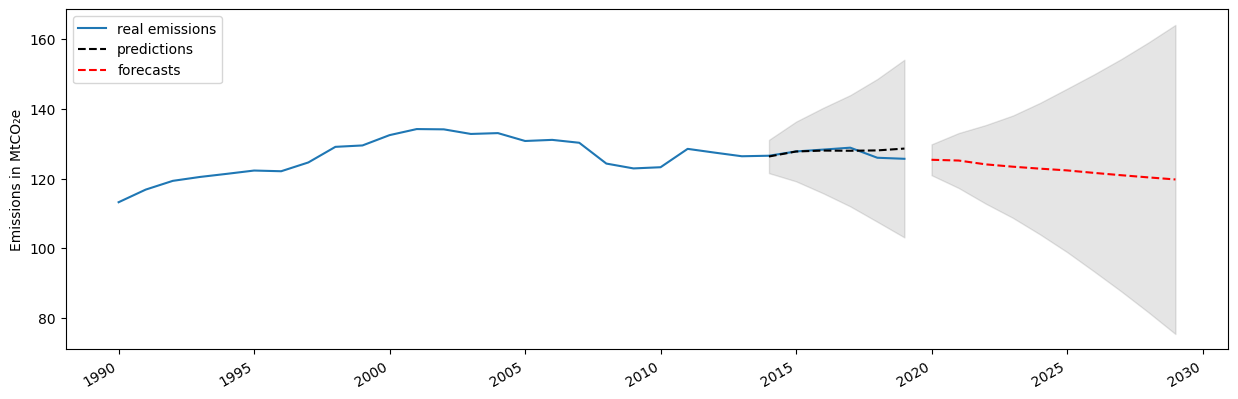

In [6]:
class statistics_model:
    """ 
    Preprocess, fit, predit, show errors and visualisation for statistical model ARIMA
    
    """    
    def __init__(self, p_values: range, d_values: range, q_values: range):
        
        self.df = preprocess_and_evaluate.get_df(country, sector, gas)
        self.train, self.test = train_test_split(self.df, test_size = 0.2, shuffle = False)
        self.p_values = p_values
        self.d_values = d_values
        self.q_values = q_values
        
    def best_order_arima(self) -> (tuple, float):
        """ Find best value order for p, d and q """
        
        best_score, best_params = float("inf"), None
        for p in self.p_values:
            for d in self.d_values:
                for q in self.q_values:
                    order = (p,d,q)
                    warnings.filterwarnings("ignore")
                    model = sm.tsa.arima.ARIMA(self.train, order=order).fit()
                    predictions = model.predict(start=len(self.train), end=len(self.train) + len(self.test)-1)
                    error = mean_absolute_error(self.test, predictions)
                    if error < best_score:
                        best_params = order
                        best_score = error
   
        return best_params, best_score
    
    def predict_arima(self) -> (pd.DataFrame, pd.DataFrame):
        """ Fit and predict ARIMA model """
        
        # Fit Arima for predictions
        best_params = self.best_order_arima()[0]
        arima = sm.tsa.arima.ARIMA(self.train, order=best_params)
        arima_fitted = arima.fit()
        arima_pred = arima_fitted.get_forecast(steps=6).summary_frame() 

        # Fit with entire dataset
        arima = sm.tsa.arima.ARIMA(self.df, order=best_params)
        arima_fitted = arima.fit()

        # Forecast for 10 years
        arima_forecasts = arima_fitted.get_forecast(steps=10).summary_frame() 
        

        return arima_pred, arima_forecasts

    
    def show_error(self):
        """ Show error ARIMA model """
        
        # Get predictions and Forecast
        arima_pred, arima_forecasts = self.predict_arima()
        
        # Calculate score
        score = preprocess_and_evaluate.calculate_scores(self.test, arima_pred['mean'])
        df_score = pd.DataFrame(score, columns=['arima'])

        # Display results
        barWidth = 0.4
        bars = ('mae', 'rmse', 'mape', 'r2')
        x_pos = np.arange(len(bars))
        plt.bar(x_pos, df_score['arima'], width = barWidth, label = 'arima errors')
        plt.xticks(x_pos, bars)
        plt.title("Errors")
        plt.legend();    
    
    
    def visualisation_arima_model(self):
        """ Show visualisation for reality, test predictions and 10 years forecast """
        
        # Get predictions and Forecast
        arima_pred, arima_forecasts = self.predict_arima()
        
        # Display results
        fig, ax = plt.subplots(figsize = (15,5))
        plt.plot(self.df, label = 'real emissions')
        arima_pred['mean'].plot(ax = ax, style = 'k--', label = 'predictions') 
        arima_forecasts['mean'].plot(ax = ax, style = '--', color = 'red', label = 'forecasts') 
        ax.fill_between(arima_pred.index, arima_pred['mean_ci_lower'], 
                        arima_pred['mean_ci_upper'], color='k', alpha=0.1)
        ax.fill_between(arima_forecasts.index, arima_forecasts['mean_ci_lower'], 
                        arima_forecasts['mean_ci_upper'], color='k', alpha=0.1)

        plt.ylabel("Emissions in MtCO₂e")
        plt.legend(loc = 'upper left');
        
# Instanciate, show errors and forecast
stat = statistics_model(p_values=p_values, d_values=d_values, q_values=q_values)
stat.show_error()
stat.visualisation_arima_model()


2022-12-18 19:29:13.761655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


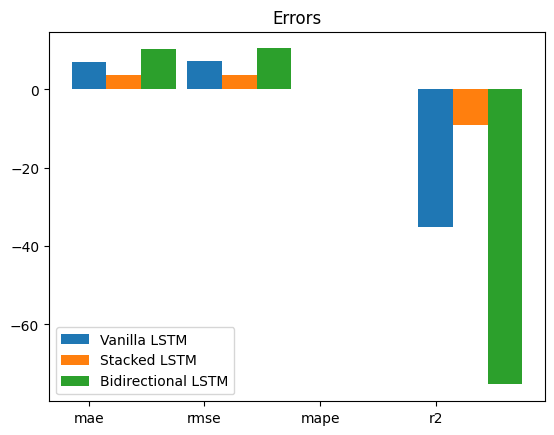

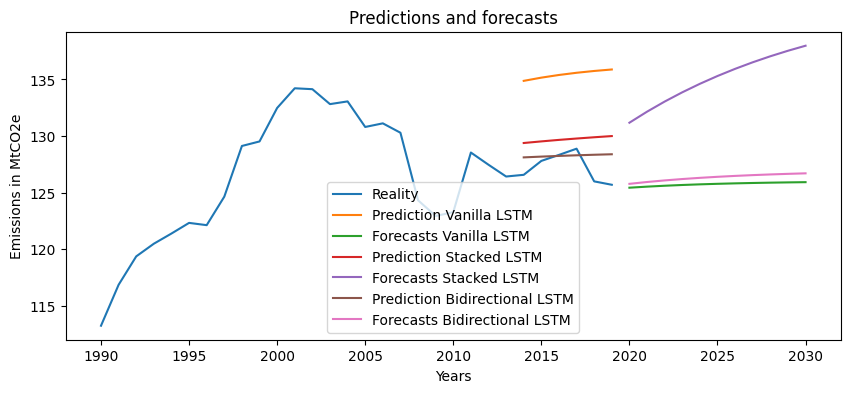

In [7]:
class deep_learning_models:
    """ 
    Preprocess, fit, predit, show errors and visualisation for deep learning models : 
    Vanilla LSTM, Stacked LSTM, Bidirectional LSTM
    
    """ 
    
    def __init__(self):
        self.df = preprocess_and_evaluate.get_df(country, sector, gas)
        self.deep_learning_config = deep_learning_config
        

    def fit_model(self, X_train: pd.DataFrame, X_test: pd.DataFrame, X: np.array, y: np.array, 
                  model_name: str, n_steps: int, n_features: int) -> (np.array, np.array):
        """ Fit and predict models """
        
        if model_name == 'Vanilla LSTM':

            model = Sequential()
            model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mean_absolute_error')

            # fit model
            model.fit(X, y, epochs=200, verbose=0)   

            #predictions
            n_years = self.df.shape[0] - X.shape[0] + X_test.shape[0]
            Xinput = X[-1]

            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_steps, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            predictions = Xinput[-X_test.shape[0]:]  

            #reset model and train on full dataset
            model.reset_states()

            X, y = preprocess_and_evaluate.split_sequence(self.df.values, n_steps)
            n_features = 1
            X = X.reshape((X.shape[0], X.shape[1], n_features))

            model.fit(X, y, epochs=200, verbose=0)

            #forecasts
            Xinput = X[-1]
            n_years = self.df.shape[0] - X.shape[0] + 11
            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_steps, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            forecasts = Xinput[-11:] 

            return predictions, forecasts

        if model_name == 'Stacked LSTM':
            
        # define model
            model = Sequential()
            model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
            model.add(LSTM(50, activation='relu'))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mean_absolute_error')
            # fit model
            model.fit(X, y, epochs=200, verbose=0)

            #predictions
            n_years = self.df.shape[0] - X.shape[0] + X_test.shape[0]
            Xinput = X[-1]

            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_steps, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            predictions = Xinput[-X_test.shape[0]:]  

            #reset model and train on full dataset
            model.reset_states()

            X, y = preprocess_and_evaluate.split_sequence(self.df.values, n_steps)
            n_features = 1
            X = X.reshape((X.shape[0], X.shape[1], n_features))

            model.fit(X, y, epochs=200, verbose=0)

            #forecasts
            Xinput = X[-1]
            n_years = self.df.shape[0] - X.shape[0] + 11
            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_steps, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            forecasts = Xinput[-11:] 

            return predictions, forecasts

        if model_name == 'Bidirectional LSTM':

            # define model
            model= Sequential()
            model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mean_absolute_error')

            # fit model
            model.fit(X, y, epochs=200, verbose=0)

            #predictions
            n_years = self.df.shape[0] - X.shape[0] + X_test.shape[0]
            Xinput = X[-1]

            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_steps, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            predictions = Xinput[-X_test.shape[0]:]  

            #reset model and train on full dataset
            model.reset_states()

            X, y = preprocess_and_evaluate.split_sequence(self.df.values, n_steps)
            n_features = 1
            X = X.reshape((X.shape[0], X.shape[1], n_features))

            model.fit(X, y, epochs=200, verbose=0)

            #forecasts
            Xinput = X[-1]
            n_years = self.df.shape[0] - X.shape[0] + 11
            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_steps, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            forecasts = Xinput[-11:]

            return predictions, forecasts
        
    def get_error(self) -> (pd.DataFrame, np.array, np.array, pd.DataFrame):
        """ Calculate error for deeplearning models """
        
        df_score = pd.DataFrame(columns=[])
        X_train, X_test = train_test_split(self.df, test_size = 0.2, shuffle = False)
        
        for model_name, feat in self.deep_learning_config.items():

            n_features = 1
            X, y = preprocess_and_evaluate.split_sequence(X_train.values, feat['n_step'])
            X = X.reshape((X.shape[0], X.shape[1], n_features))

            predictions, forecasts = self.fit_model(X_train, X_test, X, y, model_name, 
                                               feat['n_step'], n_features)
            
            score = preprocess_and_evaluate.calculate_scores(X_test, predictions)           
            df_temp = pd.DataFrame(score, columns=[model_name])
            df_score = pd.concat([df_score, df_temp], axis=1)
            
        return X_test, predictions, forecasts, df_score

              
    def show_error(self):
        """ Visualise error for models """

        X_test, predictions, forecasts, df_score = self.get_error()

        barWidth = 0.3
        bars = ('mae', 'rmse', 'mape', 'r2')
        x_pos = np.arange(len(bars))
        x2 = [r + barWidth for r in x_pos]
        x3 = [r + barWidth for r in x2]
        position_list = [x_pos, x2, x3]

        for model_name, position in zip(enumerate(self.deep_learning_config.items()), position_list):
            
            plt.bar(position, df_score[list(deep_learning_config.keys())[model_name[0]]], 
                    width = barWidth, label = list(deep_learning_config.keys())[model_name[0]])
            
        plt.title("Errors")
        plt.xticks(x_pos, bars)
        plt.legend();


    def dl_model_visualisation(self):
        """ Show visualisation for reality, test predictions and 10 years forecast """
        
        #Plot graph   
        plt.figure(figsize = (10,4))
        plt.plot(self.df.index.year, self.df, label ='Reality')
        plt.xlabel('Years')
        plt.ylabel('Emissions in MtCO2e')
        plt.title('Predictions and forecasts')

        for model_name, feat in self.deep_learning_config.items():
            
            #Get variables for predictions 
            X_test, predictions, forecasts, df_score = self.get_error() 
            
            #Plot predictions
            plt.plot(X_test.index.year, predictions ,label= f'Prediction {model_name}')
            plt.plot(range(2020, 2031), forecasts, label = f'Forecasts {model_name}')

        plt.legend()
        plt.show();

# Instanciate, show errors and forecast
dl = deep_learning_models()
dl.show_error()
dl.dl_model_visualisation()

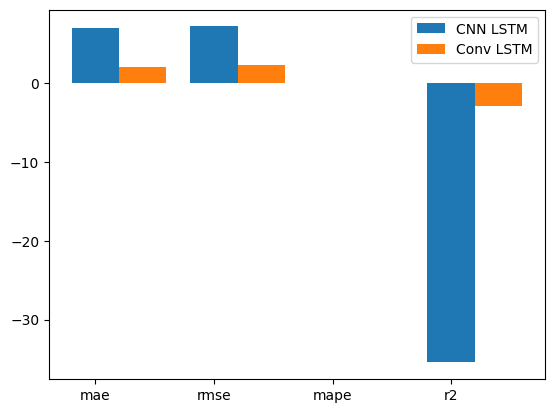

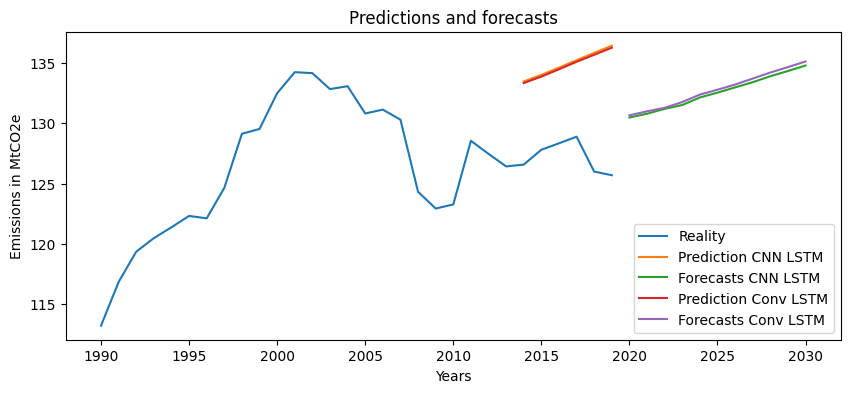

In [8]:
class cnn_models:
    """ 
    Preprocess, fit, predit, show errors and visualisation for Convolutional Neural Networks : 
    CNN LSTM, Conv LSTM
    
    """    
    
    def __init__(self):
        self.df = preprocess_and_evaluate.get_df(country, sector, gas)
        self.cnn_config = cnn_config

    def fit_model(self, X_train: pd.DataFrame, X_test:pd.DataFrame, X: np.array, y: np.array, model_name: str, 
                  n_steps: int, n_seq: int , n_steps_seq: int, n_features: int) -> (np.array, np.array) :
        """ Fit and predict models """
        
        if model_name == 'CNN LSTM':

            model = Sequential()
            model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps_seq, n_features)))
            model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
            model.add(TimeDistributed(Flatten()))
            model.add(LSTM(50, activation='relu'))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mean_absolute_error')
            # fit model

            model.fit(X, y, epochs=500, verbose=0)

            #predictions
            n_years = self.df.shape[0] - X.shape[0] + X_test.shape[0]
            Xinput = X[-1].reshape(-1,1)

            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_seq, n_steps_seq, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            predictions = Xinput[-X_test.shape[0]:]  

            #reset model and train on full dataset
            model.reset_states()

            X, y = preprocess_and_evaluate.split_sequence(self.df.values, n_steps)
            n_features = 1
            X = X.reshape((X.shape[0], n_seq, n_steps_seq, n_features))

            model.fit(X, y, epochs=200, verbose=0)

            #forecasts
            Xinput = X[-1].reshape(-1,1)
            n_years = self.df.shape[0] - X.shape[0] + 11
            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_seq, n_steps_seq, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            forecasts = Xinput[-11:] 

            return predictions, forecasts
        
        if model_name == 'Conv LSTM':
            
            # define model
            model = Sequential()
            model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_seq, n_features)))
            model.add(Flatten())
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mean_absolute_error')

            # fit model
            model.fit(X, y, epochs=500, verbose=0) 

            #predictions
            n_years = self.df.shape[0] - X.shape[0] + X_test.shape[0]
            Xinput = X[-1].reshape(-1,1)

            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_seq, 1, n_steps_seq, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            predictions = Xinput[-X_test.shape[0]:]  

            #reset model and train on full dataset
            model.reset_states()
            
            n_features = 1
            X, y = preprocess_and_evaluate.split_sequence(self.df.values, n_steps)
            X = X.reshape((X.shape[0], n_seq, 1, n_steps_seq, n_features))

            model.fit(X, y, epochs=200, verbose=0)

            #forecasts
            Xinput = X[-1].reshape(-1,1)
            n_years = self.df.shape[0] - X.shape[0] + 11
            
            for i in range(n_years):
                x_input = Xinput[-n_steps:]
                x_input = x_input.reshape((1, n_seq, 1, n_steps_seq, n_features))
                y = model.predict(x_input, verbose=0)
                Xinput = np.concatenate((Xinput, y))

            forecasts = Xinput[-11:] 

            return predictions, forecasts
        
    def get_error(self) -> (pd.DataFrame, np.array, np.array, pd.DataFrame):
        """ Calculate error for cnn models """
        
        df_score = pd.DataFrame(columns=[])
 
        for model_name, feat in self.cnn_config.items():

            if not ((feat['n_steps'] >= feat['n_seq']) and (feat['n_seq'] >= feat['n_steps_seq'])):
                print('Paramètres incompatibles : veuillez choisir n_steps >= n_seq >= n_steps_seq')

            else :         
                X_train, X_test = train_test_split(self.df, test_size = 0.2, shuffle = False)                   

                # split into samples
                X, y = preprocess_and_evaluate.split_sequence(X_train.values, feat['n_steps'])

               # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
                n_features = 1
                if model_name == 'CNN LSTM':

                    X = X.reshape((X.shape[0], feat['n_seq'], feat['n_steps_seq'], n_features))

                elif model_name == 'Conv LSTM':

                    X = X.reshape((X.shape[0], feat['n_seq'], 1, feat['n_steps_seq'], n_features))

                predictions, forecasts = self.fit_model(X_train, X_test, X, y, model_name, feat['n_steps'], 
                                                        feat['n_seq'], feat['n_steps_seq'], n_features)

                score = preprocess_and_evaluate.calculate_scores(X_test, predictions)
                df_temp = pd.DataFrame(score, columns=[model_name])
                df_score = pd.concat([df_score, df_temp], axis=1)
            
        return X_test, predictions, forecasts, df_score
        
    def show_error(self):
        """ Visualise error for cnn models """

        X_test, predictions, forecasts, df_score = self.get_error()
                
        barWidth = 0.4
        bars = ('mae', 'rmse', 'mape', 'r2')
        x_pos = np.arange(len(bars))
        x2 = [r + barWidth for r in x_pos]
        position_list= [x_pos, x2]
        
        for model_name, position in zip(enumerate(self.cnn_config.items()), position_list):
            
            plt.bar(position, df_score[list(cnn_config.keys())[model_name[0]]], 
                    width = barWidth, label = list(cnn_config.keys())[model_name[0]])

        plt.xticks(x_pos, bars)
        plt.legend();
        

    def cnn_model_visualisation(self):
        """ Show visualisation for reality, test predictions and 10 years forecast """
        
        # Plot graph
        plt.figure(figsize = (10,4))
        plt.plot(self.df.index.year, self.df, label ='Reality')
        plt.xlabel('Years')
        plt.ylabel('Emissions in MtCO2e')
        plt.title('Predictions and forecasts')

        for model_name, feat in self.cnn_config.items():

            X_test, predictions, forecasts, df_score = self.get_error()

            plt.plot(X_test.index.year, predictions ,label= f'Prediction {model_name}')
            plt.plot(range(2020, 2031), forecasts, label = f'Forecasts {model_name}')

        plt.legend()
        plt.show();

# Instanciate, show errors and forecast
dl = cnn_models()
dl.show_error()
dl.cnn_model_visualisation()

In [ ]:
############

In [ ]:
# This class is not used in the current code. For performance and speed reasons we are using 
# an already formated file transformed with this script.
# We make it avaible if you want to transform data from the website 'climatewatchdata.org'.

class tool_pre_process:
    """ 
    Preprocess from original Data Frame and allows criterias selection such as Country, Sector or Gas.
    calculates scores for model evaluation : mae, rmse, mape, r2 
    """
    
    def __init__(self, filename: str):
        self.filename = filename
        
    def get_year_in_colomn(self):
        """ Preprocess original Data Frame from 'climatewatchdata.org' to get year in column """
        
        # Import DataFrame of historical emmission in Europe by Country, Sector and Gas from 1990 to 2019
        df = pd.read_csv(self.filename)

        # Drop unused columns
        df = df.drop(['Data source', 'Unit'], axis=1)
        countries = df.Country.unique().tolist()
        countries.remove('European Union (27)')

        # Create years list
        years_list = ['2019', '2018', '2017', '2016',
               '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007',
               '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998',
               '1997', '1996', '1995', '1994', '1993', '1992','1991', '1990']

        # Get values in row for years
        final_df_europe = pd.DataFrame(columns=['Country', 'Sector', 'Gas', 'year', 'cons'])

        for country in countries:
            temp_df = df[df['Country'] == country].reset_index() 
            for year in years_list :
                for row, value in enumerate(df[df['Country'] == country].reset_index()[year]):
                    temp_df.loc[row, 'Country'] = country
                    temp_df.loc[row, 'year'] = year
                    temp_df.loc[row, 'cons'] = value
                final_df_europe = pd.concat([final_df_europe, temp_df], axis=0)

        # Ajust df by deletting years columns and temporary index
        del_column = ['index', '2019', '2018', '2017', '2016',
               '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007',
               '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998',
               '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990']
        for column in del_column:
            del final_df_europe[column]

        # Rename columns and show final df
        final_df_europe = final_df_europe.rename(
            columns={"Country": "country", "Sector": "sector", "Unit":"unit", "Gas":"gas"})  
        
        return final_df_europe
    
    def get_df(self, country: str, sector: str, gas: str):
        """ Get and initialize df """
        
        df = self.get_year_in_colomn()
        if sector == 'Industrial Processes':
            df.dropna(inplace = True)
            
        df = df.set_index('year')
        df = df[(df['country'] == country) & (df['sector'] == sector) & (df['gas'] == gas)]
        df = df.drop(['country', 'sector', 'gas'], axis=1)
        df.index = pd.to_datetime(df.index, format='%Y')
        df = df.sort_values(by='year')
        
        return df
    
    def calculate_scores(y_true: np.array , y_pred: np.array):
        """ Calculate scores for models : mar, rmse, mape, r2 """
        
        mae = round(mean_absolute_error(y_true,y_pred), 3)
        rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 3)
        mape = round(mean_absolute_percentage_error(y_true, y_pred), 3)
        r2 = round(r2_score(y_true,y_pred), 3)
        
        return mae, rmse, mape, r2
    
    def split_sequence(sequence, n_steps):
        """ Split a univariate sequence into samples - Used for deep learning """
        
        X, y = list(), list()
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

prep = preprocess_and_evaluate(filename)
prep.get_df(country, sector, gas)